# Read Sea Ice Concentration files from OSI SAF and CCI CDRs

This notebook holds examples of reading netCDF product files in the Sea Ice Concentration Climate Data Records from the EUMETSAT OSI SAF and ESA CCI.

In [1]:
import xarray as xr
import numpy as np
from datetime import date

from matplotlib import pylab as plt
from matplotlib import cm

In [2]:
dt = date(2007,9,15)
area = 'nh'

In [3]:
def get_sic_filename(dt, area, cdr='osisaf-v3'):
    
    if cdr == 'osisaf-v3':
        fn = 'ice_conc_{a:}_ease2-250_cdr-v3p0_{d:%Y%m%d}1200.nc'.format(a=area, d=dt)
    elif cdr == 'osisaf-v2':
        fn = 'ice_conc_{a:}_ease2-250_cdr-v2p0_{d:%Y%m%d}1200.nc'.format(a=area, d=dt)
    else:
        raise ValueError("Do not know about CDR '{}'".format(cdr))
    
    return fn

def get_sic_url(dt, area, cdr='osisaf-v3'):
    
    fn = get_sic_filename(dt, area, cdr=cdr)
    
    if cdr == 'osisaf-v3':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/{d:%Y/%m}/{f:}'.format(d=dt, f=fn)
    elif cdr == 'osisaf-v2':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_v2p0_files/{d:%Y/%m}/{f:}'.format(d=dt, f=fn)
    else:
        raise ValueError("Do not know about CDR '{}'".format(cdr))
    
    return url

print(get_sic_url(dt, area))

https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/2007/09/ice_conc_nh_ease2-250_cdr-v3p0_200709151200.nc


## Access a SIC field as a xarray dataset using the OpenDap protocol

In [4]:
url = get_sic_url(dt, area)
ds = xr.open_dataset(url)
print(ds)

<xarray.Dataset>
Dimensions:                         (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                            (time) datetime64[ns] 2007-09-15T12:00:00
  * xc                              (xc) float64 -5.388e+03 ... 5.388e+03
  * yc                              (yc) float64 5.388e+03 ... -5.388e+03
    lat                             (yc, xc) float32 ...
    lon                             (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid          int32 ...
    time_bnds                       (time, nv) datetime64[ns] ...
    ice_conc                        (time, yc, xc) float64 ...
    raw_ice_conc_values             (time, yc, xc) float64 ...
    total_standard_uncertainty      (time, yc, xc) float64 ...
    smearing_standard_uncertainty   (time, yc, xc) float64 ...
    algorithm_standard_uncertainty  (time, yc, xc) float64 ...
    status_flag                     (time, yc, xc) float32 ...
Attributes: (12/43

## Simple plot

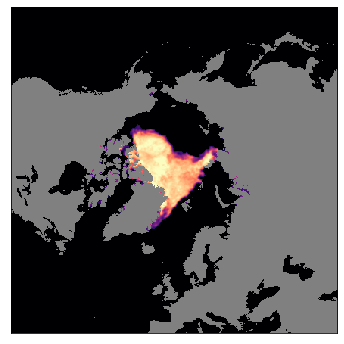

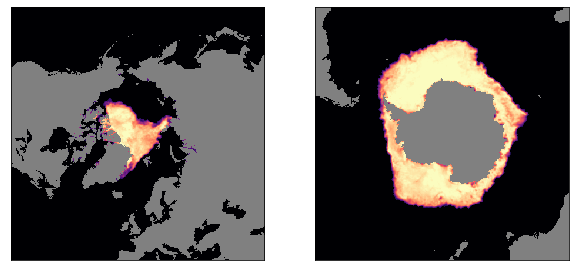

In [5]:
def simple_plot(ds, ax=None):
    cmap = cm.magma.with_extremes(bad='grey')
    
    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)
    
    ax.imshow(ds['ice_conc'][0], interpolation='none', cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax

# plot 1 panel
simple_plot(ds)
plt.show()

# plot two panels side-by-side
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
simple_plot(ds, ax=ax)
ax = fig.add_subplot(1,2,2)
simple_plot(xr.open_dataset(get_sic_url(dt,'sh')), ax=ax)
plt.show()

## Plot a contour of the sea-ice cover

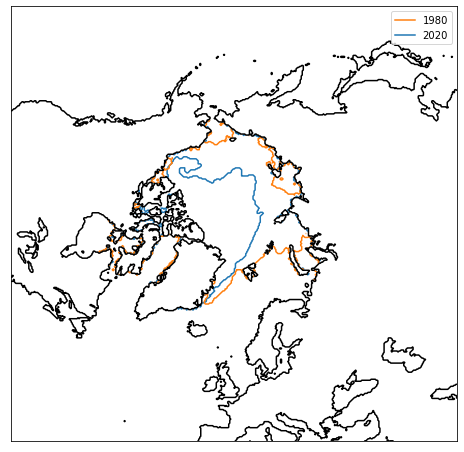

In [6]:
import matplotlib.lines as mlines


# access the two dates
ds_1980 = xr.open_dataset(get_sic_url(date(1980,9,15),'nh'))
ds_2020 = xr.open_dataset(get_sic_url(date(2020,9,15),'nh'))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

# plot the sea ice contour (at 50% SIC level), and the lines for the legend
ax.contour(ds_2020['ice_conc'][0], levels=(0.5,), colors='C0', origin='upper',)
ln_2020 = mlines.Line2D([], [], color='C0', label='2020')

ax.contour(ds_1980['ice_conc'][0], levels=(0.5,), colors='C1', origin='upper')
ln_1980 = mlines.Line2D([], [], color='C1', label='1980')

# add contour of the landmask
landmask=ds_2020['ice_conc'][0].to_masked_array().mask
ax.contour(landmask.astype('float'), levels=(0.5,), colors='k', origin='upper')

# add the legend
ax.legend(handles=[ln_1980, ln_2020])

# remove x/y-ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()